In [12]:
from qiskit_aer import AerSimulator
from qiskit import *
import supermarq
from qiskit.providers.fake_provider import *
import numpy as np 
import os

########## INPUT ############
f=5 # number of fake_backend want to choose
lower_limit= 3 # the lower limit of qubits for the circuit
upper_limit= 20 # the lower limit of qubits for the circuit
steps= 3 #jump in qubit numbers
name_of_algo='hamiltonian'

In [13]:
#all_fakes=[FakeAlmadenV2,FakeArmonkV2,FakeAthensV2,FakeAuckland,FakeBelemV2,FakeBoeblingenV2,FakeBogotaV2,FakeBrooklynV2,FakeBurlingtonV2,FakeCairoV2,FakeCambridgeV2,FakeCasablancaV2,FakeEssexV2,FakeGeneva,FakeGuadalupeV2,FakeHanoiV2,FakeJakartaV2,FakeJohannesburgV2,FakeKolkataV2,FakeLagosV2,FakeLimaV2,FakeLondonV2,FakeManhattanV2,FakeManilaV2,FakeMelbourneV2,FakeMontrealV2,FakeMumbaiV2,FakeNairobiV2,FakeOslo,FakeOurenseV2,FakeParisV2,FakePerth,FakePrague,FakePoughkeepsieV2,FakeQuitoV2,FakeRochesterV2,FakeRomeV2,FakeSantiagoV2,FakeSherbrooke,FakeSingaporeV2,FakeSydneyV2,FakeTorontoV2,FakeValenciaV2,FakeVigoV2,FakeWashingtonV2,FakeYorktownV2]
#selected_fakes = random.sample(all_fakes, f)
#selected_fakes  # having any randomly selected 5 fake backends out of 46 mentioned in the inital list
selected_fakes=[FakeBoeblingenV2,FakeRomeV2,FakeGeneva,FakeTorontoV2,FakeRochesterV2]

In [14]:
benchmarks=[]
for i in range(lower_limit,upper_limit,steps):
    label = name_of_algo+str(i)
    benchmarks.append((supermarq.hamiltonian_simulation.HamiltonianSimulation(i),label))
for i in benchmarks:
    circuit=i[0].qiskit_circuit()
    print("--------------------------",i[1],"---------------------------")
    #circuit.draw(output="mpl")
    #print(circuit.draw())       #uncomment it to print all the circuits

-------------------------- hamiltonian3 ---------------------------
-------------------------- hamiltonian6 ---------------------------
-------------------------- hamiltonian9 ---------------------------
-------------------------- hamiltonian12 ---------------------------
-------------------------- hamiltonian15 ---------------------------
-------------------------- hamiltonian18 ---------------------------


In [15]:
benchmark_features = {}
for benchmark, label in benchmarks:
    benchmark_features[label] = [
        supermarq.converters.compute_communication_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_depth_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_entanglement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_liveness_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_measurement_with_qiskit(benchmark.qiskit_circuit()),
        supermarq.converters.compute_parallelism_with_qiskit(benchmark.qiskit_circuit()),]
print(benchmark_features)

{'hamiltonian3': [0.6666666666666666, 1.0, 0.26666666666666666, 0.7333333333333333, 0.0, 0.25], 'hamiltonian6': [0.3333333333333333, 1.0, 0.30303030303030304, 0.4298245614035088, 0.0, 0.1473684210526316], 'hamiltonian9': [0.2222222222222222, 1.0, 0.3137254901960784, 0.30158730158730157, 0.0, 0.10267857142857142], 'hamiltonian12': [0.16666666666666666, 1.0, 0.3188405797101449, 0.23198198198198197, 0.0, 0.07862407862407862], 'hamiltonian15': [0.13333333333333333, 1.0, 0.3218390804597701, 0.18840579710144928, 0.0, 0.06366459627329192], 'hamiltonian18': [0.1111111111111111, 1.0, 0.3238095238095238, 0.15858585858585858, 0.0, 0.05347593582887701]}


In [16]:
import time
import pandas as pd
from IPython.display import display
jobs =[]
data=[]
print("=============SCORES OF ALL THE CIRCUITS=============")    
for backend in selected_fakes:
    print("BACKEND-NAME :: ", backend().name)
    for benchmark, label in benchmarks:
        circuit=benchmark.qiskit_circuit()
        score_list=[]
        timetaken=[]
        for i in range(0,1):
            start=time.time()
            job = backend().run(circuit, shots=1000)
            result = job.result()
            counts = job.result(0).get_counts()
            score = benchmark.score(counts)
            end=time.time()-start
            score_list.append(score)
            t=job.result(0).time_taken
            timetaken.append(t)
            print(i+1,"th iteration,", label ," Execution time::",t, "Total Time Taken ::",end )
            #print(label ," ExecutionTime:",t,"& Total time:",end)
        #print("------------------------------------------")
        score = np.mean(score_list) 
        sd = np.std(score_list)
        execution_time = np.mean(timetaken)
        dictionary={}
        dictionary["Backend_Time"]=backend().name
        dictionary["Ciruit_Name"]=label    
        dictionary["Execution_Time"]=execution_time
        dictionary["Total_Time"]=end
        data.append(dictionary)
        jobs.append((label,benchmark,backend,job,score,sd,execution_time,end))
#jobs
df = pd.DataFrame(data)
display(df)
df.to_excel(r"./output_Hamiltonian.xlsx", index=False)

=============SCORES OF ALL THE CIRCUITS=============
BACKEND-NAME ::  fake_boeblingen
1 th iteration Execution time:: 0.28557658195495605 Total Time Taken :: 0.9471161365509033
1 th iteration Execution time:: 0.7127301692962646 Total Time Taken :: 1.3852686882019043
1 th iteration Execution time:: 1.2851006984710693 Total Time Taken :: 1.990774154663086
1 th iteration Execution time:: 1.2284736633300781 Total Time Taken :: 1.9591383934020996
1 th iteration Execution time:: 3.206225872039795 Total Time Taken :: 4.0740063190460205
1 th iteration Execution time:: 20.674774169921875 Total Time Taken :: 23.269944667816162
BACKEND-NAME ::  fake_rome
1 th iteration Execution time:: 0.47745323181152344 Total Time Taken :: 0.6262328624725342
1 th iteration Execution time:: 0.08149528503417969 Total Time Taken :: 0.38564181327819824
1 th iteration Execution time:: 0.7210252285003662 Total Time Taken :: 0.9583821296691895
1 th iteration Execution time:: 0.5506024360656738 Total Time Taken :: 0.82

,Backend_Time,Ciruit_Name,Execution_Time,Total_Time
0,fake_boeblingen,hamiltonian3,0.285577,0.947116
1,fake_boeblingen,hamiltonian6,0.712730,1.385269
2,fake_boeblingen,hamiltonian9,1.285101,1.990774
3,fake_boeblingen,hamiltonian12,1.228474,1.959138
4,fake_boeblingen,hamiltonian15,3.206226,4.074006
5,fake_boeblingen,hamiltonian18,20.674774,23.269945
6,fake_rome,hamiltonian3,0.477453,0.626233
7,fake_rome,hamiltonian6,0.081495,0.385642
8,fake_rome,hamiltonian9,0.721025,0.958382
9,fake_rome,hamiltonian12,0.550602,0.828859


In [17]:
all_scores={}  
all_fake_names=[]
all_fake_scores=[]
for i in selected_fakes:
    fakes=i
    #print("SELCETED_FAKES:: ",i)
    i={}
    for label,benchmark,backend,job,score,sd,exec,tot in jobs:
        #supermarq.plotting.plot_results([score], [label])
        if fakes == backend:
            i[label] = score
    device_scores = 'device_score_' +str(fakes().name)
    all_scores[device_scores]= i
    all_fake_scores.append(i)
    all_fake_names.append(device_scores)   
#print(all_scores)    

In [18]:
for label,benchmark,backend,job,score,sd,exec,tot in jobs:
    print("USED BACKEND::",backend().name,"; CIRCUIT_NAME:",label, "; SCORE =",score)
    #supermarq.plotting.plot_results([score], [label]) #uncomment it to print all the circuits
    #print("-----------------------------------------------------------")

USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9311132760733927
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian6 ; SCORE = 0.936279942740059
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian9 ; SCORE = 0.9308910538511701
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian12 ; SCORE = 0.9236132760733939
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian15 ; SCORE = 0.9207132760733934
USED BACKEND:: fake_boeblingen ; CIRCUIT_NAME: hamiltonian18 ; SCORE = 0.926613276073506
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltonian3 ; SCORE = 0.9581132760733926
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltonian6 ; SCORE = 0.9614466094067255
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltonian9 ; SCORE = 0.97789105385117
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltonian12 ; SCORE = 0.9838632760733941
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltonian15 ; SCORE = 0.9810466094067283
USED BACKEND:: fake_rome ; CIRCUIT_NAME: hamiltoni

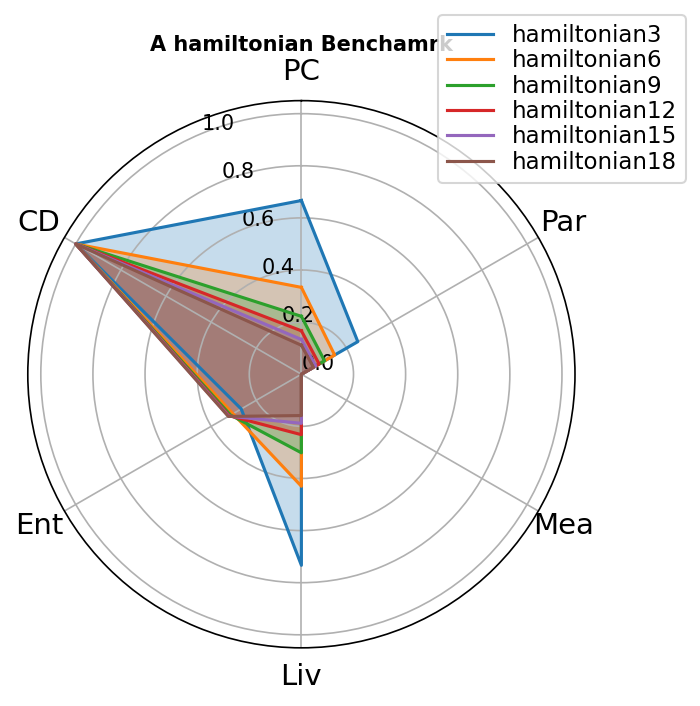

In [19]:
names=[]
scores=[]
X="A "+name_of_algo+' Benchamrk'
for i,j in benchmark_features.items():
    names.append(i)
    scores.append(j)
supermarq.plotting.plot_benchmark([X,names,scores],
        spoke_labels=["PC", "CD", "Ent", "Liv", "Mea", "Par"],show=True)

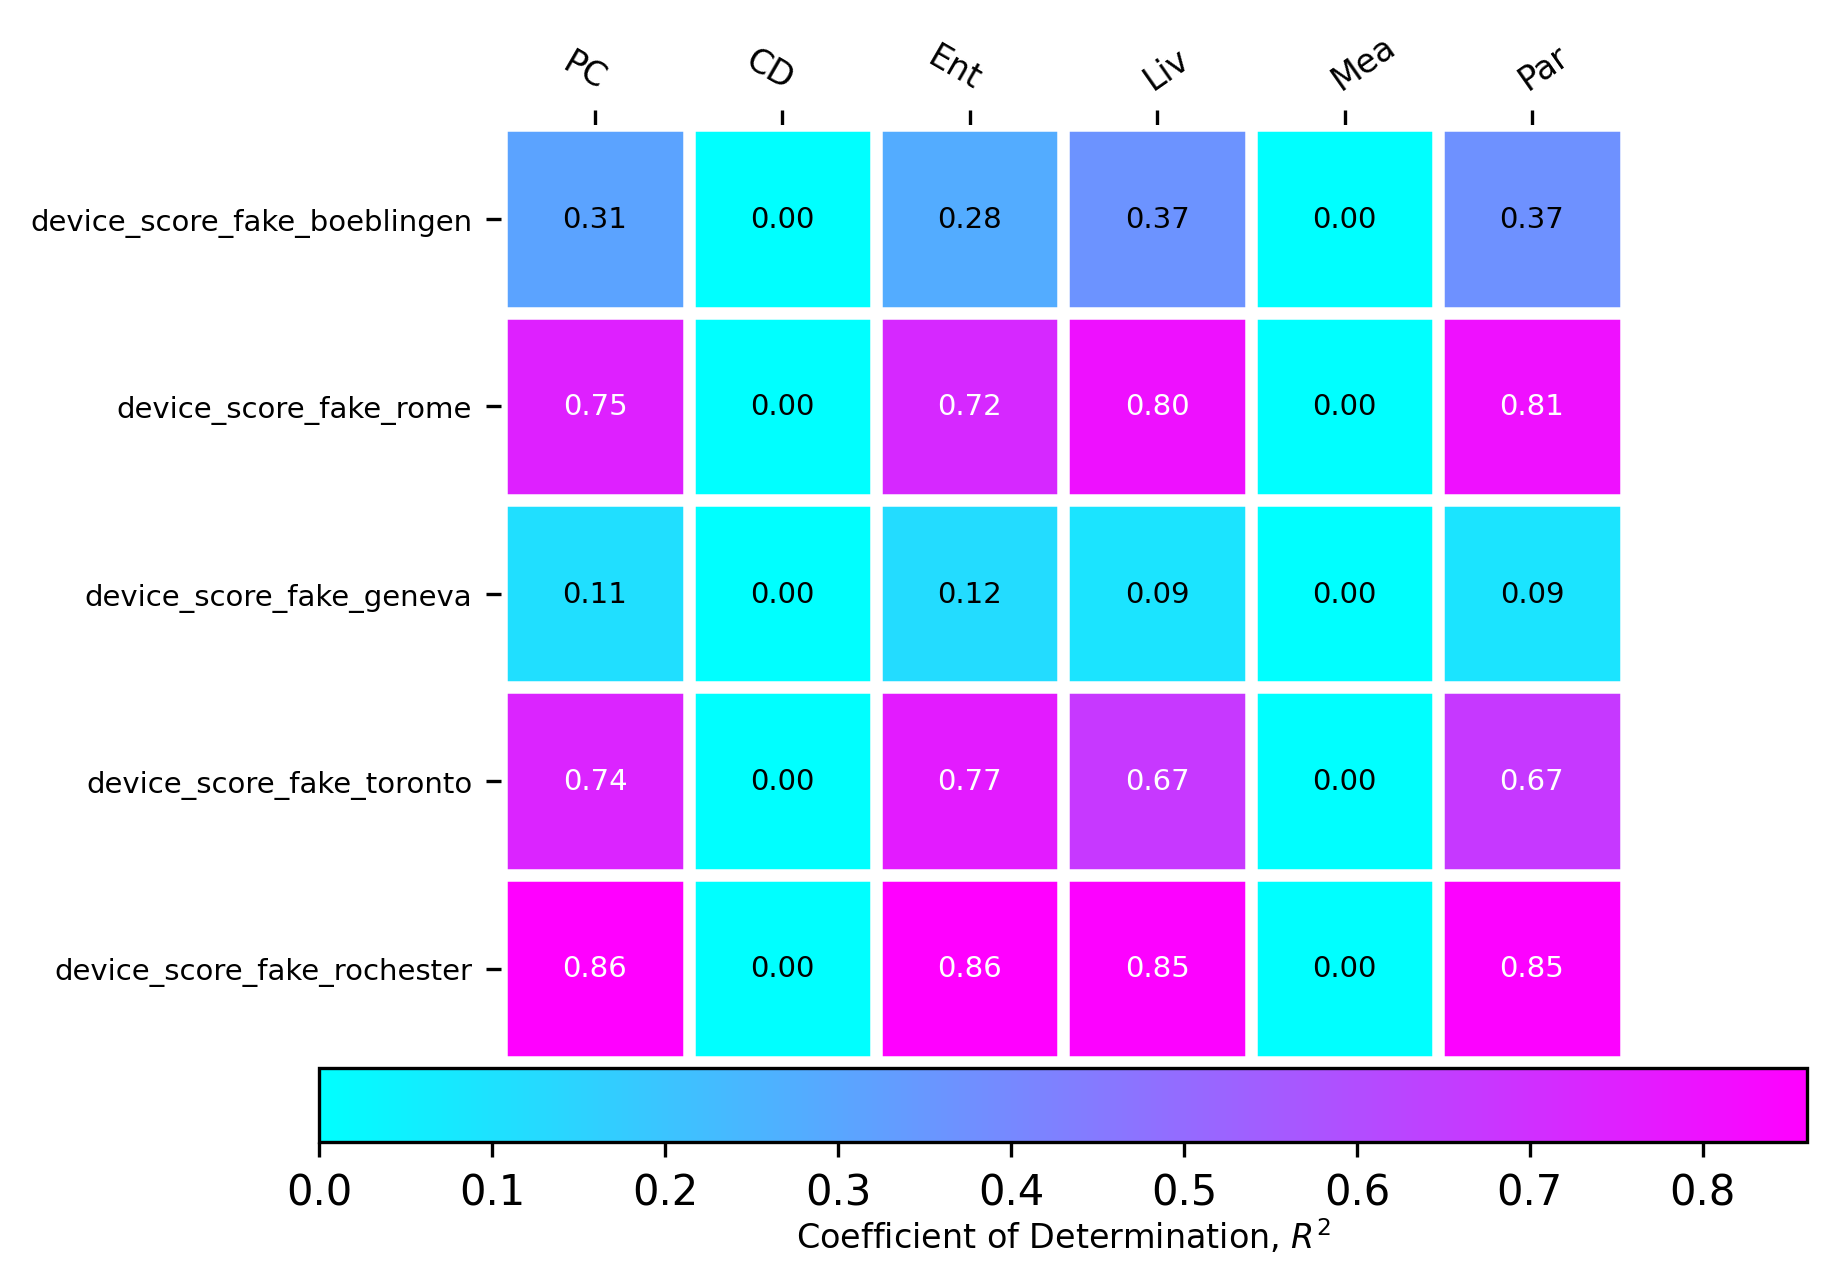

In [20]:
supermarq.plotting.plot_correlations(benchmark_features,all_fake_scores,["PC", "CD", "Ent", "Liv", "Mea", "Par"],device_name=all_fake_names,show=True,)

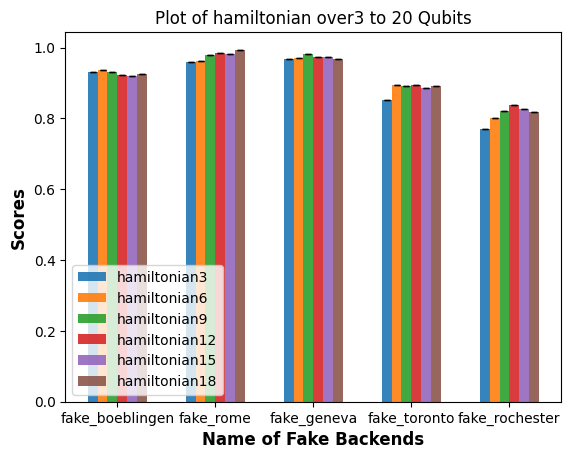

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np
all_fake_names=[]
all_score=[]
all_sd=[]
all_ckt=[]
v='Plot of '+name_of_algo+' over'+str(lower_limit)+' to '+str(upper_limit)+ ' Qubits'
for i in selected_fakes:
    all_fake_names.append(i().name)    
for benchmark, label in benchmarks:
    i=[]
    j=[]
    k=[]
    for ckt,benchmark,backend,job,score,sd,exec,tot in jobs:
        if ckt == label:
            i.append(score)
            j.append(sd)
    all_ckt.append(label)
    all_score.append(i)
    all_sd.append(j)
num_bars = len(all_score)
width = 0.1
x = np.arange(len(all_fake_names)) # x-axis positions for each bar
fig, ax = plt.subplots()
for i in range(num_bars):               # Create bars for each category with appropriate offsets
    ax.bar(x + i * width, all_score[i], width=width, label=f'Bar {i+1}', 
           yerr=all_sd[i],align='center',alpha=0.9,ecolor='black',capsize=2)
ax.set_xlabel('Name of Fake Backends',fontweight ='bold',fontsize = 12)
ax.set_ylabel('Scores',fontweight ='bold',fontsize = 12)
ax.set_title(v)
ax.set_xticks(x + (num_bars - 1) * width / 2)
ax.set_xticklabels(all_fake_names)
ax.legend(all_ckt,loc="lower left")
#ax.grid(True)
plt.show()

In [22]:
import resource
def get_memory():
    usage = resource.getrusage(resource.RUSAGE_SELF)
    max_mem = usage.ru_maxrss/1024 #in MB
    return max_mem
get_memory()

1436.54296875